In [ ]:
#All my data is stored in the cloud on my drive so need to connect to it
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf
from IPython.display import display
from PIL import Image
import os, shutil
import pandas as pd

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras import backend
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import smart_resize
np.random.seed(23)

In [ ]:
#Make sure there is a gpu to use
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
#See what kind of GPU I got allocated this run
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Oct 12 19:30:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    33W / 250W |    345MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
baseDir = '/content/drive/MyDrive/FlowerData' #Where all the data is stored
modelDir = '/content/drive/MyDrive/FlowerModels' #Where I will save all the models I used

In [ ]:
testDir = os.path.join(baseDir, 'test')
trainDir = os.path.join(baseDir, 'train')
validationDir = os.path.join(baseDir, 'validation')

In [ ]:
#I check to make sure we are able to retrieve the data and resize all images to 250*250 without distortion
trainDS = tf.keras.preprocessing.image_dataset_from_directory(
  trainDir,
  seed=23,
  image_size=(250, 250),
  crop_to_aspect_ratio=True,
  label_mode = 'categorical',
  shuffle = True,
  batch_size=43)

validationDS = tf.keras.preprocessing.image_dataset_from_directory(
  validationDir,
  seed=23,
  image_size=(250, 250),
  crop_to_aspect_ratio=True,
  shuffle = True,
  label_mode = 'categorical',
  batch_size=43)

testDS = tf.keras.preprocessing.image_dataset_from_directory(
  testDir,
  seed=23,
  image_size=(250, 250),
  crop_to_aspect_ratio=True,
  shuffle = True,
  label_mode = 'categorical',
  batch_size=43)

Found 7564 files belonging to 90 classes.
Found 1811 files belonging to 90 classes.
Found 875 files belonging to 90 classes.


# Data Augmentation Example

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3),width_factor=(-0.3, -0.2),fill_mode="nearest")
])

In [ ]:
print(os.path.join(trainDir,"bird_of_paradise/bird_of_paradise1.png"))

/content/drive/MyDrive/FlowerData/train/bird_of_paradise/bird_of_paradise1.png


In [ ]:
from keras.preprocessing import image
img = image.load_img(os.path.join(trainDir,"bird_of_paradise/bird_of_paradise1.png"))
x = image.img_to_array(img)
x = tf.keras.preprocessing.image.smart_resize(x,size=(250,250))
x = x.reshape((1,) + x.shape)

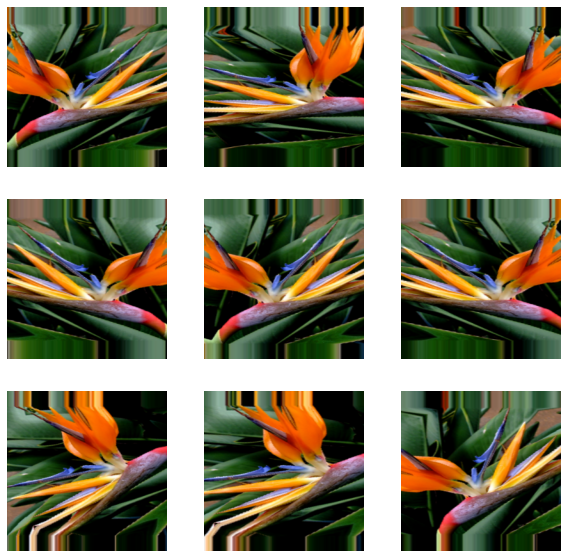

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(x)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")


# Transfer Learning

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications import MobileNet

In [ ]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout, Flatten, Activation, Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, SeparableConv2D
from tensorflow.keras.layers import BatchNormalization

#Xception Model

In [ ]:
xceptionBase = Xception(include_top=False ,weights="imagenet", input_shape=(250,250,3))

In [ ]:
xceptionBase.trainable = False 

In [ ]:
xceptionBase.summary()

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3),width_factor=(-0.3, -0.2),fill_mode="nearest")
])

preprocessInputXception = tf.keras.applications.xception.preprocess_input

In [ ]:
#Xception Model w/ Data Augmentation
backend.clear_session()
visible = tf.keras.Input(shape=(250, 250, 3))
x = data_augmentation(visible)
x = preprocessInputXception(x)
x = xceptionBase(x, training=False)
x = Flatten()(x)
hidden = Dense(256, activation='relu')(x)
drop = Dropout(0.5)(hidden)
hidden = Dense(128, activation='relu')(drop)
drop = Dropout(0.2)(hidden)
output = Dense(90, activation='softmax')(drop)

xceptionFrozenModel = Model(inputs=visible, outputs=output)

In [ ]:
xceptionFrozenModel.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 250, 250, 3)]     0         
_________________________________________________________________
sequential_5 (Sequential)    (None, 250, 250, 3)       0         
_________________________________________________________________
tf.math.truediv_3 (TFOpLambd (None, 250, 250, 3)       0         
_________________________________________________________________
tf.math.subtract_3 (TFOpLamb (None, 250, 250, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
flatten_2 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               3355

In [ ]:
checkpoint_filepathXceptionFTL = os.path.join(modelDir, 'XceptionFTLModel/Checkpoint')
model_checkpoint_callback_XFTL = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepathXceptionFTL,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
xceptionFrozenModel.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

history = xceptionFrozenModel.fit(
    trainDS,
    epochs=50, 
    validation_data=validationDS, 
    verbose = 1,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights = True), model_checkpoint_callback_XFTL])

Epoch 1/50
176/176 [==============================] - 4972s 28s/step - loss: 4.7885 - accuracy: 0.0300 - val_loss: 4.3714 - val_accuracy: 0.0491
INFO:tensorflow:Assets written to: /content/drive/MyDrive/FlowerModels/XceptionFTLModel/Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
176/176 [==============================] - 322s 2s/step - loss: 4.4033 - accuracy: 0.0411 - val_loss: 4.3219 - val_accuracy: 0.0613
INFO:tensorflow:Assets written to: /content/drive/MyDrive/FlowerModels/XceptionFTLModel/Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/50
176/176 [==============================] - 322s 2s/step - loss: 4.3973 - accuracy: 0.0394 - val_loss: 4.3520 - val_accuracy: 0.0453
Epoch 4/50
176/176 [==============================] - 319s 2s/step - loss: 4.3809 - accuracy: 0.0420 - val_loss: 4.3070 - val_accuracy: 0.0607
Epoch 5/50
176/176 [==============================] - 319s 2s/step - loss: 4.3447 - accuracy: 0.0476 - val_loss: 4.3052 - val_accuracy: 0.0491
Epoch 6/50
176/176 [==============================] - 318s 2s/step - loss: 4.3205 - accuracy: 0.0520 - val_loss: 4.2666 - val_accuracy: 0.0541
Epoch 7/50
176/176 [==============================] - 320s 2s/step - loss: 4.3169 - accuracy: 0.0509 - val_loss: 4.2109 - val_accuracy: 0.0635
INFO:tensorflow:Assets written to: /content/drive/MyDrive/FlowerModels/XceptionFTLModel/Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/50
176/176 [==============================] - 321s 2s/step - loss: 4.2833 - accuracy: 0.0501 - val_loss: 4.1499 - val_accuracy: 0.0740
INFO:tensorflow:Assets written to: /content/drive/MyDrive/FlowerModels/XceptionFTLModel/Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 9/50
176/176 [==============================] - 320s 2s/step - loss: 4.2605 - accuracy: 0.0516 - val_loss: 4.1532 - val_accuracy: 0.0729
Epoch 10/50
176/176 [==============================] - 318s 2s/step - loss: 4.2667 - accuracy: 0.0477 - val_loss: 4.1177 - val_accuracy: 0.0718
Epoch 11/50
176/176 [==============================] - 320s 2s/step - loss: 4.2515 - accuracy: 0.0508 - val_loss: 4.0838 - val_accuracy: 0.0718
Epoch 12/50
176/176 [==============================] - 319s 2s/step - loss: 4.2268 - accuracy: 0.0539 - val_loss: 4.0765 - val_accuracy: 0.0756
INFO:tensorflow:Assets written to: /content/drive/MyDrive/FlowerModels/XceptionFTLModel/Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 13/50
176/176 [==============================] - 320s 2s/step - loss: 4.2307 - accuracy: 0.0539 - val_loss: 4.1591 - val_accuracy: 0.0607
Epoch 14/50
176/176 [==============================] - 319s 2s/step - loss: 4.2300 - accuracy: 0.0501 - val_loss: 4.0739 - val_accuracy: 0.0696
Epoch 15/50
176/176 [==============================] - 319s 2s/step - loss: 4.2303 - accuracy: 0.0533 - val_loss: 4.0417 - val_accuracy: 0.0685
Epoch 16/50
176/176 [==============================] - 319s 2s/step - loss: 4.2154 - accuracy: 0.0525 - val_loss: 4.0504 - val_accuracy: 0.0801
INFO:tensorflow:Assets written to: /content/drive/MyDrive/FlowerModels/XceptionFTLModel/Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 17/50
176/176 [==============================] - 321s 2s/step - loss: 4.1967 - accuracy: 0.0559 - val_loss: 4.0583 - val_accuracy: 0.0812
INFO:tensorflow:Assets written to: /content/drive/MyDrive/FlowerModels/XceptionFTLModel/Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 18/50
176/176 [==============================] - 322s 2s/step - loss: 4.1994 - accuracy: 0.0557 - val_loss: 4.0505 - val_accuracy: 0.0779
Epoch 19/50
176/176 [==============================] - 318s 2s/step - loss: 4.2123 - accuracy: 0.0539 - val_loss: 4.0390 - val_accuracy: 0.0779
Epoch 20/50
176/176 [==============================] - 319s 2s/step - loss: 4.1704 - accuracy: 0.0591 - val_loss: 4.1033 - val_accuracy: 0.0806
Epoch 21/50
176/176 [==============================] - 318s 2s/step - loss: 4.1796 - accuracy: 0.0562 - val_loss: 4.0006 - val_accuracy: 0.0834
INFO:tensorflow:Assets written to: /content/drive/MyDrive/FlowerModels/XceptionFTLModel/Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 22/50
176/176 [==============================] - 323s 2s/step - loss: 4.1691 - accuracy: 0.0591 - val_loss: 4.3436 - val_accuracy: 0.0828
Epoch 23/50
176/176 [==============================] - 327s 2s/step - loss: 4.1379 - accuracy: 0.0648 - val_loss: 3.9824 - val_accuracy: 0.0718
Epoch 24/50
176/176 [==============================] - 325s 2s/step - loss: 4.1435 - accuracy: 0.0591 - val_loss: 3.9761 - val_accuracy: 0.0756
Epoch 25/50
176/176 [==============================] - 324s 2s/step - loss: 4.1087 - accuracy: 0.0611 - val_loss: 4.0178 - val_accuracy: 0.0795
Epoch 26/50
176/176 [==============================] - 325s 2s/step - loss: 4.1219 - accuracy: 0.0579 - val_loss: 3.9363 - val_accuracy: 0.0883
INFO:tensorflow:Assets written to: /content/drive/MyDrive/FlowerModels/XceptionFTLModel/Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 27/50
176/176 [==============================] - 326s 2s/step - loss: 4.1387 - accuracy: 0.0632 - val_loss: 3.9937 - val_accuracy: 0.0784
Epoch 28/50
176/176 [==============================] - 325s 2s/step - loss: 4.1034 - accuracy: 0.0591 - val_loss: 3.9318 - val_accuracy: 0.0845
Epoch 29/50
176/176 [==============================] - 325s 2s/step - loss: 4.1032 - accuracy: 0.0625 - val_loss: 3.9144 - val_accuracy: 0.0812
Epoch 30/50
176/176 [==============================] - 325s 2s/step - loss: 4.0922 - accuracy: 0.0613 - val_loss: 3.9593 - val_accuracy: 0.0944
INFO:tensorflow:Assets written to: /content/drive/MyDrive/FlowerModels/XceptionFTLModel/Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 31/50
176/176 [==============================] - 325s 2s/step - loss: 4.1020 - accuracy: 0.0628 - val_loss: 3.9909 - val_accuracy: 0.0823
Epoch 32/50
176/176 [==============================] - 325s 2s/step - loss: 4.0875 - accuracy: 0.0645 - val_loss: 3.8668 - val_accuracy: 0.0861
Epoch 33/50
176/176 [==============================] - 326s 2s/step - loss: 4.0843 - accuracy: 0.0621 - val_loss: 3.8786 - val_accuracy: 0.0906
Epoch 34/50
176/176 [==============================] - 324s 2s/step - loss: 4.0751 - accuracy: 0.0643 - val_loss: 3.8554 - val_accuracy: 0.0933
Epoch 35/50
176/176 [==============================] - 325s 2s/step - loss: 4.0740 - accuracy: 0.0649 - val_loss: 3.8423 - val_accuracy: 0.0972
INFO:tensorflow:Assets written to: /content/drive/MyDrive/FlowerModels/XceptionFTLModel/Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 36/50
176/176 [==============================] - 324s 2s/step - loss: 4.0501 - accuracy: 0.0632 - val_loss: 3.8462 - val_accuracy: 0.0939
Epoch 37/50
176/176 [==============================] - 324s 2s/step - loss: 4.0177 - accuracy: 0.0694 - val_loss: 3.7981 - val_accuracy: 0.1055
INFO:tensorflow:Assets written to: /content/drive/MyDrive/FlowerModels/XceptionFTLModel/Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 38/50
176/176 [==============================] - 324s 2s/step - loss: 3.9816 - accuracy: 0.0719 - val_loss: 3.7695 - val_accuracy: 0.1264
INFO:tensorflow:Assets written to: /content/drive/MyDrive/FlowerModels/XceptionFTLModel/Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 39/50
176/176 [==============================] - 324s 2s/step - loss: 3.9710 - accuracy: 0.0730 - val_loss: 3.6863 - val_accuracy: 0.1071
Epoch 40/50
176/176 [==============================] - 324s 2s/step - loss: 3.9426 - accuracy: 0.0723 - val_loss: 3.6782 - val_accuracy: 0.1104
Epoch 41/50
176/176 [==============================] - 324s 2s/step - loss: 3.9116 - accuracy: 0.0751 - val_loss: 3.6550 - val_accuracy: 0.1038
Epoch 42/50
176/176 [==============================] - 323s 2s/step - loss: 3.8893 - accuracy: 0.0792 - val_loss: 3.6153 - val_accuracy: 0.1165
Epoch 43/50
176/176 [==============================] - 325s 2s/step - loss: 3.8431 - accuracy: 0.0833 - val_loss: 3.6475 - val_accuracy: 0.1160
Epoch 44/50
176/176 [==============================] - 324s 2s/step - loss: 3.8748 - accuracy: 0.0785 - val_loss: 3.5704 - val_accuracy: 0.1204
Epoch 45/50
176/176 [==============================] - 325s 2s/step - loss: 3.8486 - accuracy: 0.0768 - val_loss: 3.5492 - val_accuracy:

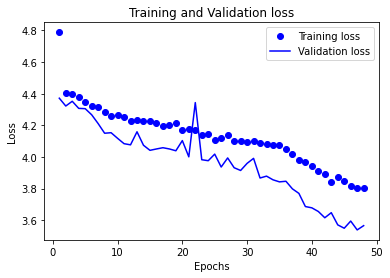

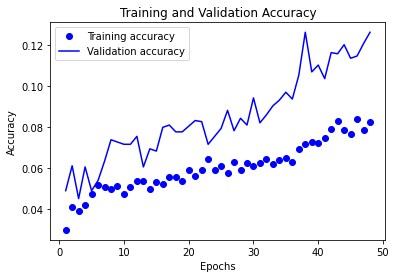

In [ ]:
hist = pd.DataFrame(history.history)
plt.plot(range(1,len(hist.loss) + 1),hist.loss, 'bo',label = 'Training loss')
plt.plot(range(1,len(hist.loss) + 1), hist.val_loss, 'b',label = 'Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(range(1,len(hist.loss) + 1),hist.accuracy, 'bo',label = 'Training accuracy')
plt.plot(range(1,len(hist.loss) + 1), hist.val_accuracy, 'b',label = 'Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc = xceptionFrozenModel.evaluate(testDS)
print('test_acc:', test_acc)
xceptionFrozenModel.save('/content/drive/MyDrive/FlowerModels/XceptionFTLModel/XFTL.h5')

21/21 [==============================] - 851s 25s/step - loss: 3.7313 - accuracy: 0.1211
test_acc: 0.12114285677671432


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Unfrozen Xception Base

In [ ]:
# From looking at the architecture in the previous output I know that I want to unfreeze the last block which is block 14. Block 14 had 6 layers so I will unfreeze the last six. 
xceptionBase = Xception(include_top=False ,weights="imagenet", input_shape=(250,250,3))
for layer in xceptionBase.layers[:-6]:
  layer.trainable = False
for layer in xceptionBase.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fa5bafcb290> False
<keras.layers.convolutional.Conv2D object at 0x7fa5b89aa4d0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fa5b89adc10> False
<keras.layers.core.Activation object at 0x7fa5bee9fb50> False
<keras.layers.convolutional.Conv2D object at 0x7fa5bc163ed0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fa5be5cf050> False
<keras.layers.core.Activation object at 0x7fa5bbdc3710> False
<keras.layers.convolutional.SeparableConv2D object at 0x7fa5bc2eca10> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fa5ba597d90> False
<keras.layers.core.Activation object at 0x7fa5beb70690> False
<keras.layers.convolutional.SeparableConv2D object at 0x7fa5b9690710> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fa5bb11f990> False
<keras.layers.convolutional.Conv2D object at 0x7fa5bbed9cd0> Fa

In [ ]:
xceptionBase.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 124, 124, 32) 864         input_9[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 124, 124, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 124, 124, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3),width_factor=(-0.3, -0.2),fill_mode="nearest")
])

preprocessInputXception = tf.keras.applications.xception.preprocess_input

In [ ]:
#Xception Model w/ Data Augmentation
backend.clear_session()
visible = tf.keras.Input(shape=(250, 250, 3))
x = data_augmentation(visible)
x = preprocessInputXception(x)
x = xceptionBase(x, training=False)
x = Flatten()(x)
hidden = Dense(256, activation='relu')(x)
drop = Dropout(0.5)(hidden)
hidden = Dense(128, activation='relu')(drop)
drop = Dropout(0.2)(hidden)
output = Dense(90, activation='softmax')(drop)

xceptionUnFrozenModel = Model(inputs=visible, outputs=output)

In [ ]:
xceptionUnFrozenModel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 250, 250, 3)]     0         
_________________________________________________________________
sequential_6 (Sequential)    (None, 250, 250, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 250, 250, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 250, 250, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               335546

In [ ]:
checkpoint_filepathXceptionUnTL = os.path.join(modelDir, 'XceptionUnTLModel/Checkpoint')
model_checkpoint_callback_XUTL = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepathXceptionUnTL,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
xceptionUnFrozenModel.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

history = xceptionUnFrozenModel.fit(
    trainDS,
    epochs=50, 
    validation_data=validationDS, 
    verbose = 1,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights = True), model_checkpoint_callback_XUTL])

Epoch 1/50
176/176 [==============================] - 331s 2s/step - loss: 4.2895 - accuracy: 0.0768 - val_loss: 4.0303 - val_accuracy: 0.0988
INFO:tensorflow:Assets written to: /content/drive/MyDrive/FlowerModels/XceptionUnTLModel/Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
176/176 [==============================] - 326s 2s/step - loss: 3.7340 - accuracy: 0.1542 - val_loss: 3.5820 - val_accuracy: 0.1839
INFO:tensorflow:Assets written to: /content/drive/MyDrive/FlowerModels/XceptionUnTLModel/Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/50
176/176 [==============================] - 325s 2s/step - loss: 3.1745 - accuracy: 0.2433 - val_loss: 2.8284 - val_accuracy: 0.2916
INFO:tensorflow:Assets written to: /content/drive/MyDrive/FlowerModels/XceptionUnTLModel/Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/50
176/176 [==============================] - 329s 2s/step - loss: 2.5188 - accuracy: 0.3595 - val_loss: 2.3865 - val_accuracy: 0.4119
INFO:tensorflow:Assets written to: /content/drive/MyDrive/FlowerModels/XceptionUnTLModel/Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/50
176/176 [==============================] - 328s 2s/step - loss: 2.0544 - accuracy: 0.4613 - val_loss: 1.9691 - val_accuracy: 0.5069
INFO:tensorflow:Assets written to: /content/drive/MyDrive/FlowerModels/XceptionUnTLModel/Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/50
176/176 [==============================] - 329s 2s/step - loss: 1.7551 - accuracy: 0.5385 - val_loss: 1.8678 - val_accuracy: 0.5450
INFO:tensorflow:Assets written to: /content/drive/MyDrive/FlowerModels/XceptionUnTLModel/Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/50
176/176 [==============================] - 327s 2s/step - loss: 1.5263 - accuracy: 0.5887 - val_loss: 1.6445 - val_accuracy: 0.5809
INFO:tensorflow:Assets written to: /content/drive/MyDrive/FlowerModels/XceptionUnTLModel/Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/50
176/176 [==============================] - 330s 2s/step - loss: 1.3559 - accuracy: 0.6437 - val_loss: 1.6000 - val_accuracy: 0.5991
INFO:tensorflow:Assets written to: /content/drive/MyDrive/FlowerModels/XceptionUnTLModel/Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 9/50
176/176 [==============================] - 328s 2s/step - loss: 1.2212 - accuracy: 0.6793 - val_loss: 1.4828 - val_accuracy: 0.6300
INFO:tensorflow:Assets written to: /content/drive/MyDrive/FlowerModels/XceptionUnTLModel/Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 10/50
176/176 [==============================] - 330s 2s/step - loss: 1.1088 - accuracy: 0.7081 - val_loss: 1.4382 - val_accuracy: 0.6582
INFO:tensorflow:Assets written to: /content/drive/MyDrive/FlowerModels/XceptionUnTLModel/Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 11/50
176/176 [==============================] - 328s 2s/step - loss: 1.0095 - accuracy: 0.7306 - val_loss: 1.5365 - val_accuracy: 0.6687
INFO:tensorflow:Assets written to: /content/drive/MyDrive/FlowerModels/XceptionUnTLModel/Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 12/50
176/176 [==============================] - 329s 2s/step - loss: 0.9288 - accuracy: 0.7566 - val_loss: 1.3854 - val_accuracy: 0.6770
INFO:tensorflow:Assets written to: /content/drive/MyDrive/FlowerModels/XceptionUnTLModel/Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 13/50
176/176 [==============================] - 328s 2s/step - loss: 0.9222 - accuracy: 0.7603 - val_loss: 1.4903 - val_accuracy: 0.6505
Epoch 14/50
176/176 [==============================] - 326s 2s/step - loss: 0.8288 - accuracy: 0.7849 - val_loss: 1.3152 - val_accuracy: 0.7002
INFO:tensorflow:Assets written to: /content/drive/MyDrive/FlowerModels/XceptionUnTLModel/Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 15/50
176/176 [==============================] - 329s 2s/step - loss: 0.7397 - accuracy: 0.8071 - val_loss: 1.3785 - val_accuracy: 0.6858
Epoch 16/50
176/176 [==============================] - 327s 2s/step - loss: 0.7247 - accuracy: 0.8191 - val_loss: 1.3403 - val_accuracy: 0.7101
INFO:tensorflow:Assets written to: /content/drive/MyDrive/FlowerModels/XceptionUnTLModel/Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 17/50
176/176 [==============================] - 328s 2s/step - loss: 0.6664 - accuracy: 0.8306 - val_loss: 1.5833 - val_accuracy: 0.6814
Epoch 18/50
176/176 [==============================] - 326s 2s/step - loss: 0.6579 - accuracy: 0.8320 - val_loss: 1.4162 - val_accuracy: 0.7129
INFO:tensorflow:Assets written to: /content/drive/MyDrive/FlowerModels/XceptionUnTLModel/Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 19/50
176/176 [==============================] - 327s 2s/step - loss: 0.6243 - accuracy: 0.8428 - val_loss: 1.3205 - val_accuracy: 0.7267
INFO:tensorflow:Assets written to: /content/drive/MyDrive/FlowerModels/XceptionUnTLModel/Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 20/50
176/176 [==============================] - 327s 2s/step - loss: 0.5610 - accuracy: 0.8548 - val_loss: 1.4225 - val_accuracy: 0.7245
Epoch 21/50
176/176 [==============================] - 326s 2s/step - loss: 0.5643 - accuracy: 0.8588 - val_loss: 1.3493 - val_accuracy: 0.7372
INFO:tensorflow:Assets written to: /content/drive/MyDrive/FlowerModels/XceptionUnTLModel/Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 22/50
176/176 [==============================] - 325s 2s/step - loss: 0.5373 - accuracy: 0.8612 - val_loss: 1.3641 - val_accuracy: 0.7388
INFO:tensorflow:Assets written to: /content/drive/MyDrive/FlowerModels/XceptionUnTLModel/Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 23/50
176/176 [==============================] - 328s 2s/step - loss: 0.4930 - accuracy: 0.8796 - val_loss: 1.3941 - val_accuracy: 0.7333
Epoch 24/50
176/176 [==============================] - 326s 2s/step - loss: 0.4980 - accuracy: 0.8737 - val_loss: 1.4705 - val_accuracy: 0.7250
Epoch 25/50
176/176 [==============================] - 326s 2s/step - loss: 0.4578 - accuracy: 0.8789 - val_loss: 1.5145 - val_accuracy: 0.7156
Epoch 26/50
176/176 [==============================] - 325s 2s/step - loss: 0.4260 - accuracy: 0.8904 - val_loss: 1.5274 - val_accuracy: 0.7410
INFO:tensorflow:Assets written to: /content/drive/MyDrive/FlowerModels/XceptionUnTLModel/Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 27/50
176/176 [==============================] - 327s 2s/step - loss: 0.4440 - accuracy: 0.8936 - val_loss: 1.4618 - val_accuracy: 0.7333
Epoch 28/50
176/176 [==============================] - 328s 2s/step - loss: 0.4632 - accuracy: 0.8867 - val_loss: 1.4313 - val_accuracy: 0.7366
Epoch 29/50
176/176 [==============================] - 326s 2s/step - loss: 0.4028 - accuracy: 0.9018 - val_loss: 1.4658 - val_accuracy: 0.7333
Epoch 30/50
176/176 [==============================] - 327s 2s/step - loss: 0.3867 - accuracy: 0.9047 - val_loss: 1.4688 - val_accuracy: 0.7377
Epoch 31/50
176/176 [==============================] - 328s 2s/step - loss: 0.3779 - accuracy: 0.9088 - val_loss: 1.6216 - val_accuracy: 0.7416
INFO:tensorflow:Assets written to: /content/drive/MyDrive/FlowerModels/XceptionUnTLModel/Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 32/50
176/176 [==============================] - 325s 2s/step - loss: 0.3368 - accuracy: 0.9174 - val_loss: 1.6323 - val_accuracy: 0.7311
Epoch 33/50
176/176 [==============================] - 324s 2s/step - loss: 0.3620 - accuracy: 0.9120 - val_loss: 1.7545 - val_accuracy: 0.7289
Epoch 34/50
176/176 [==============================] - 325s 2s/step - loss: 0.3897 - accuracy: 0.9117 - val_loss: 1.7035 - val_accuracy: 0.7084
Epoch 35/50
176/176 [==============================] - 323s 2s/step - loss: 0.3304 - accuracy: 0.9212 - val_loss: 1.5014 - val_accuracy: 0.7333
Epoch 36/50
176/176 [==============================] - 322s 2s/step - loss: 0.3578 - accuracy: 0.9182 - val_loss: 1.6741 - val_accuracy: 0.7118
Epoch 37/50
176/176 [==============================] - 322s 2s/step - loss: 0.3438 - accuracy: 0.9182 - val_loss: 1.4584 - val_accuracy: 0.7465
INFO:tensorflow:Assets written to: /content/drive/MyDrive/FlowerModels/XceptionUnTLModel/Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 38/50
176/176 [==============================] - 324s 2s/step - loss: 0.3054 - accuracy: 0.9264 - val_loss: 1.7582 - val_accuracy: 0.7239
Epoch 39/50
176/176 [==============================] - 324s 2s/step - loss: 0.3246 - accuracy: 0.9225 - val_loss: 1.6406 - val_accuracy: 0.7421
Epoch 40/50
176/176 [==============================] - 327s 2s/step - loss: 0.2940 - accuracy: 0.9315 - val_loss: 1.7181 - val_accuracy: 0.7410
Epoch 41/50
176/176 [==============================] - 325s 2s/step - loss: 0.2783 - accuracy: 0.9332 - val_loss: 1.7077 - val_accuracy: 0.7383
Epoch 42/50
176/176 [==============================] - 325s 2s/step - loss: 0.2994 - accuracy: 0.9315 - val_loss: 1.7373 - val_accuracy: 0.7327
Epoch 43/50
176/176 [==============================] - 325s 2s/step - loss: 0.2931 - accuracy: 0.9336 - val_loss: 1.7157 - val_accuracy: 0.7432
Epoch 44/50
176/176 [==============================] - 324s 2s/step - loss: 0.2979 - accuracy: 0.9360 - val_loss: 1.7609 - val_accuracy:

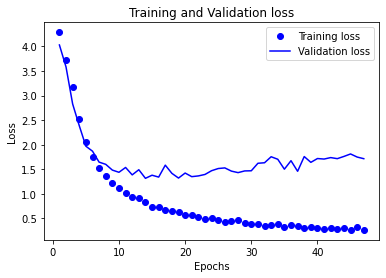

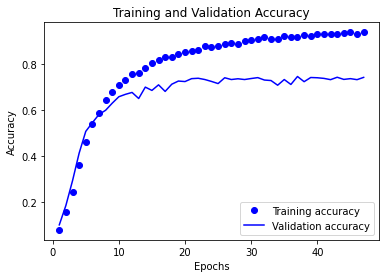

In [ ]:
hist = pd.DataFrame(history.history)
plt.plot(range(1,len(hist.loss) + 1),hist.loss, 'bo',label = 'Training loss')
plt.plot(range(1,len(hist.loss) + 1), hist.val_loss, 'b',label = 'Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(range(1,len(hist.loss) + 1),hist.accuracy, 'bo',label = 'Training accuracy')
plt.plot(range(1,len(hist.loss) + 1), hist.val_accuracy, 'b',label = 'Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc = xceptionUnFrozenModel.evaluate(testDS)
print('test_acc:', test_acc)
xceptionUnFrozenModel.save('/content/drive/MyDrive/FlowerModels/XceptionUnTLModel/XUTL.h5')

21/21 [==============================] - 38s 940ms/step - loss: 1.2915 - accuracy: 0.7726
test_acc: 0.7725714445114136


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# Best TL Model Adjusted 

In [ ]:
xceptionBase = Xception(include_top=False ,weights="imagenet", input_shape=(250,250,3))
for layer in xceptionBase.layers[:-6]:
  layer.trainable = False
for layer in xceptionBase.layers:
  print(layer, layer.trainable)

83697664/83683744 [==============================] - 2s 0us/step
<keras.engine.input_layer.InputLayer object at 0x7fd845c28150> False
<keras.layers.convolutional.Conv2D object at 0x7fd8453b3790> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fd84540e910> False
<keras.layers.core.Activation object at 0x7fd8453b3350> False
<keras.layers.convolutional.Conv2D object at 0x7fd8303175d0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fd830334050> False
<keras.layers.core.Activation object at 0x7fd830334590> False
<keras.layers.convolutional.SeparableConv2D object at 0x7fd8302c8f50> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fd8302d0ed0> False
<keras.layers.core.Activation object at 0x7fd8302db1d0> False
<keras.layers.convolutional.SeparableConv2D object at 0x7fd8302df8d0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fd8302db190> Fals

In [ ]:
xceptionBase.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 124, 124, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 124, 124, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 124, 124, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3),width_factor=(-0.3, -0.2),fill_mode="nearest")
])

preprocessInputXception = tf.keras.applications.xception.preprocess_input

In [ ]:
#Xception Model w/ Data Augmentation Optimized

backend.clear_session()
visible = tf.keras.Input(shape=(250, 250, 3))
x = data_augmentation(visible)
x = preprocessInputXception(x)
x = xceptionBase(x, training=False)
x = Flatten()(x)
hidden = Dense(512, activation='relu')(x)
batchN = BatchNormalization()(hidden)
hidden = Dense(256, activation='relu')(batchN)
drop = Dropout(0.3)(hidden)
output = Dense(90, activation='softmax')(drop)

xceptionModelThree = Model(inputs=visible, outputs=output)

In [ ]:
xceptionModelThree.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 250, 250, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 250, 250, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 250, 250, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 250, 250, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               671093

In [ ]:
checkpoint_filepathXceptionOpt = os.path.join(modelDir, 'XceptionModelThree/Checkpoint')
model_checkpoint_callback_XOPT = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepathXceptionOpt,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
xceptionModelThree.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

history = xceptionModelThree.fit(
    trainDS,
    epochs=50,
    validation_data=validationDS, 
    verbose = 1,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights = True), model_checkpoint_callback_XOPT])

Epoch 1/50
176/176 [==============================] - 3903s 21s/step - loss: 2.6926 - accuracy: 0.3488 - val_loss: 6.6961 - val_accuracy: 0.1784
INFO:tensorflow:Assets written to: /content/drive/MyDrive/FlowerModels/XceptionModelThree/Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
176/176 [==============================] - 304s 2s/step - loss: 1.5702 - accuracy: 0.5772 - val_loss: 1.9503 - val_accuracy: 0.5196
INFO:tensorflow:Assets written to: /content/drive/MyDrive/FlowerModels/XceptionModelThree/Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/50
176/176 [==============================] - 305s 2s/step - loss: 1.3410 - accuracy: 0.6269 - val_loss: 1.9642 - val_accuracy: 0.5268
INFO:tensorflow:Assets written to: /content/drive/MyDrive/FlowerModels/XceptionModelThree/Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/50
176/176 [==============================] - 308s 2s/step - loss: 1.0298 - accuracy: 0.7082 - val_loss: 1.6555 - val_accuracy: 0.5881
INFO:tensorflow:Assets written to: /content/drive/MyDrive/FlowerModels/XceptionModelThree/Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/50
176/176 [==============================] - 306s 2s/step - loss: 0.8829 - accuracy: 0.7464 - val_loss: 1.5949 - val_accuracy: 0.6074
INFO:tensorflow:Assets written to: /content/drive/MyDrive/FlowerModels/XceptionModelThree/Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/50
176/176 [==============================] - 307s 2s/step - loss: 0.7310 - accuracy: 0.7885 - val_loss: 1.2681 - val_accuracy: 0.6786
INFO:tensorflow:Assets written to: /content/drive/MyDrive/FlowerModels/XceptionModelThree/Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/50
176/176 [==============================] - 305s 2s/step - loss: 0.6677 - accuracy: 0.8018 - val_loss: 1.2402 - val_accuracy: 0.6913
INFO:tensorflow:Assets written to: /content/drive/MyDrive/FlowerModels/XceptionModelThree/Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/50
176/176 [==============================] - 305s 2s/step - loss: 0.5927 - accuracy: 0.8224 - val_loss: 1.3796 - val_accuracy: 0.6941
INFO:tensorflow:Assets written to: /content/drive/MyDrive/FlowerModels/XceptionModelThree/Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 9/50
176/176 [==============================] - 305s 2s/step - loss: 0.5744 - accuracy: 0.8318 - val_loss: 1.3404 - val_accuracy: 0.7156
INFO:tensorflow:Assets written to: /content/drive/MyDrive/FlowerModels/XceptionModelThree/Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 10/50
176/176 [==============================] - 304s 2s/step - loss: 0.5070 - accuracy: 0.8511 - val_loss: 1.1750 - val_accuracy: 0.7178
INFO:tensorflow:Assets written to: /content/drive/MyDrive/FlowerModels/XceptionModelThree/Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 11/50
176/176 [==============================] - 305s 2s/step - loss: 0.4479 - accuracy: 0.8685 - val_loss: 1.0372 - val_accuracy: 0.7587
INFO:tensorflow:Assets written to: /content/drive/MyDrive/FlowerModels/XceptionModelThree/Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 12/50
176/176 [==============================] - 306s 2s/step - loss: 0.3967 - accuracy: 0.8806 - val_loss: 1.1043 - val_accuracy: 0.7482
Epoch 13/50
176/176 [==============================] - 305s 2s/step - loss: 0.3621 - accuracy: 0.8897 - val_loss: 1.0832 - val_accuracy: 0.7642
INFO:tensorflow:Assets written to: /content/drive/MyDrive/FlowerModels/XceptionModelThree/Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 14/50
176/176 [==============================] - 307s 2s/step - loss: 0.3568 - accuracy: 0.8895 - val_loss: 1.8852 - val_accuracy: 0.6935
Epoch 15/50
176/176 [==============================] - 305s 2s/step - loss: 0.3574 - accuracy: 0.8929 - val_loss: 1.3323 - val_accuracy: 0.7355
Epoch 16/50
176/176 [==============================] - 306s 2s/step - loss: 0.2959 - accuracy: 0.9094 - val_loss: 1.2198 - val_accuracy: 0.7454
Epoch 17/50
176/176 [==============================] - 303s 2s/step - loss: 0.2871 - accuracy: 0.9088 - val_loss: 1.3189 - val_accuracy: 0.7327
Epoch 18/50
176/176 [==============================] - 304s 2s/step - loss: 0.2924 - accuracy: 0.9101 - val_loss: 1.2078 - val_accuracy: 0.7482


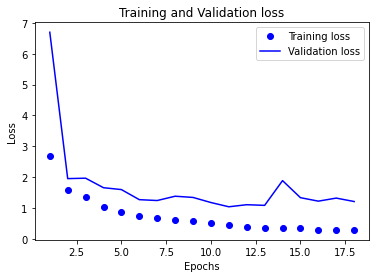

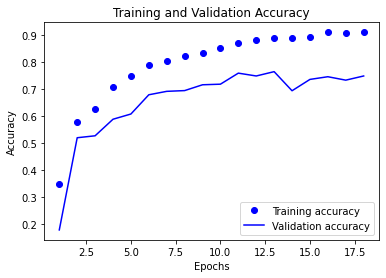

In [ ]:
hist = pd.DataFrame(history.history)
plt.plot(range(1,len(hist.loss) + 1),hist.loss, 'bo',label = 'Training loss')
plt.plot(range(1,len(hist.loss) + 1), hist.val_loss, 'b',label = 'Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(range(1,len(hist.loss) + 1),hist.accuracy, 'bo',label = 'Training accuracy')
plt.plot(range(1,len(hist.loss) + 1), hist.val_accuracy, 'b',label = 'Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc = xceptionModelThree.evaluate(testDS)
print('test_acc:', test_acc)
xceptionModelThree.save('/content/drive/MyDrive/FlowerModels/XceptionModelThree/XOPT.h5')

21/21 [==============================] - 463s 15s/step - loss: 0.8665 - accuracy: 0.7943
test_acc: 0.7942857146263123


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
